<a href="https://colab.research.google.com/github/AlecDerinBorque/PasswordManager/blob/main/Copy_of_DS_%26_AI_Final_Project_TEMPLATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start your amazing project here

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Find your cool dataset 😎 (15 min)

Recomended:

* [Kaggle](https://www.kaggle.com/datasets?sort=downloadCount&fileType=csv&minUsabilityRating=9.00+or+higher)


#Loading data (5 min)
### Step 1:
###  Upload file on folder icon

### Step 2:
###  Copy uploaded file path

### Step 3:
###  Load data into pandas dataframe using file path



In [8]:
from google.colab import drive
df = pd.read_csv('/content/video_games_sales.csv')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [9]:
# create df here
df = pd.read_csv("/content/video_games_sales.csv")
df = df[df["Year"] >= 2006].copy()
print("Rows after year filtering:", len(df))

Rows after year filtering: 10214


## EDA Process (60 min)
### Helpful questions for analysis:
###

*   How many columns do you have?

*   How many rows?
* What type of data?
* What are the main columns?


*   How many missing values do you have?
*   What's your data's distribution (graph a single attribute/feature of the data)?
* *  Histogram
* * Bar chart
* * Pie chart
* Which attributes are strongly correlated / related?

* Identify target feature?

In [10]:
df = df.drop(columns=[
    "Rank", "Name",          # not useful for modeling
    "NA_Sales", "EU_Sales",  # leakage: we cannot know these ahead of time
    "JP_Sales", "Other_Sales"
], errors="ignore")

In [11]:
# Drop rows missing Genre or Platform (critical features)
df = df.dropna(subset=["Genre", "Platform"])

# Replace missing publisher with placeholder
df["Publisher"] = df["Publisher"].fillna("Unknown")

In [12]:
df = df[df["Global_Sales"] <= 30]
df["Log_Global_Sales"] = np.log1p(df["Global_Sales"])


print("Rows after outlier removal:", len(df))

Rows after outlier removal: 10210


In [13]:
# Compute average global sales per year
year_avg = df.groupby("Year")["Global_Sales"].mean()

# Keep ONLY stable years 2006–2014
stable_years = year_avg.loc[2006:2012]

print(stable_years)


Year
2006.0    0.405855
2007.0    0.508428
2008.0    0.450652
2009.0    0.443566
2010.0    0.476926
2011.0    0.453020
2012.0    0.553333
Name: Global_Sales, dtype: float64


In [14]:
# Prepare data for trend fitting
trend_X = stable_years.index.values.reshape(-1, 1)
trend_y = stable_years.values.reshape(-1, 1)

trend_model = LinearRegression()
trend_model.fit(trend_X, trend_y)

print("Trend slope:", trend_model.coef_[0][0])
print("Trend intercept:", trend_model.intercept_[0])


Trend slope: 0.01278196241697393
Trend intercept: -25.208708167100838


In [15]:
df["Year_Adjusted"] = trend_model.predict(df["Year"].values.reshape(-1,1))


In [16]:
df = df.drop(columns=["Year"])

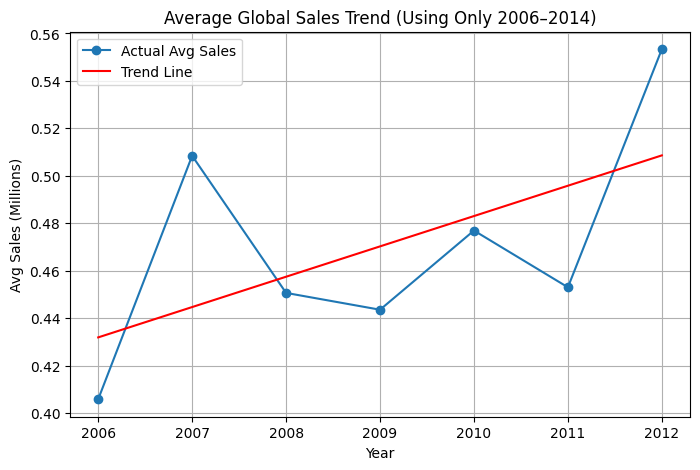

In [17]:
plt.figure(figsize=(8,5))
plt.plot(stable_years.index, stable_years.values, marker="o", label="Actual Avg Sales")
plt.plot(stable_years.index, trend_model.predict(trend_X), label="Trend Line", color="red")
plt.title("Average Global Sales Trend (Using Only 2006–2014)")
plt.xlabel("Year")
plt.ylabel("Avg Sales (Millions)")
plt.legend()
plt.grid(True)
plt.show()


# DATA CLEANING (45 min)
* Remove any unecessary columns
* Combine very similar columns (Aggregation)
* Identify Outliers (Use IQR formula)
* Remove Duplicates
* Replace or remove rows with missing values
* * KNN (Imputation)
* * median (Imputation)
* * mean (Imputation)
* * Forward fill (time-series imputation)
* * Backward fill (time-series imputation)
* * Linear interpolation (time-series imputation)
* Normalize data-set if needed
* * min-max
* * z-score


In [18]:
publisher_counts = df["Publisher"].value_counts()
df["Publisher_freq"] = df["Publisher"].map(publisher_counts)

# Optionally remove original text colum

In [19]:
# Make a copy for modeling
df_model = df.copy()

# Create label encoders
enc_genre = LabelEncoder()
enc_platform = LabelEncoder()
enc_publisher = LabelEncoder()

df_model["Genre"] = enc_genre.fit_transform(df_model["Genre"])
df_model["Platform"] = enc_platform.fit_transform(df_model["Platform"])
df_model["Publisher"] = enc_publisher.fit_transform(df_model["Publisher"])

In [20]:
X = df_model[["Genre", "Platform", "Publisher", "Year_Adjusted"]]
y = df_model["Global_Sales"]

In [21]:
X_train, x_test, Y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
rf = RandomForestRegressor(
    n_estimators=600,     # number of trees
    random_state=42,
    max_depth=40,      # allow full tree growth
    min_samples_split=7,
    min_samples_leaf=3
)

rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=40, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=600, random_state=42)

In [23]:
y_pred = rf.predict(x_test)

In [24]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Compute SSE (Sum of Squared Errors)
sse = mse * len(y_test)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
print("SSE:", sse)

MAE: 0.4706535695354615
RMSE: 1.3096660336431396
R²: 0.19610466454557152
SSE: 3502.4896943836056


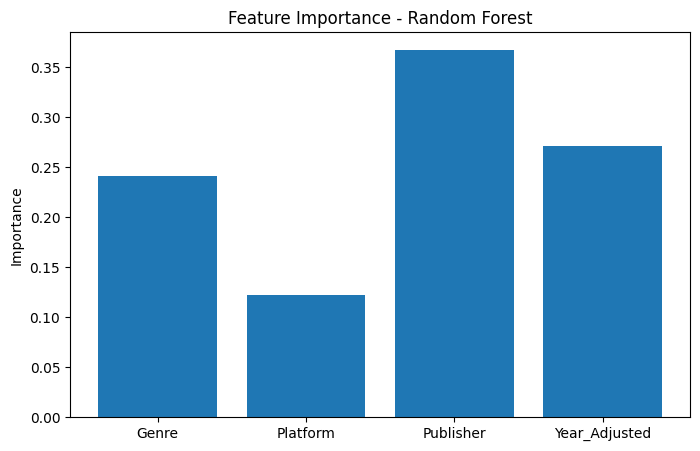

In [25]:
importances = rf.feature_importances_
feature_names = ["Genre", "Platform", "Publisher", "Year_Adjusted"]

plt.figure(figsize=(8,5))
plt.bar(feature_names, importances)
plt.title("Feature Importance - Random Forest")
plt.ylabel("Importance")
plt.show()


# MODEL BUILDING (45 min)
## Best on your data and target feature, try to choose the best model

* Classification Models
* * Decision trees
* * Rule based classfiers
* * KNN
* * Naive bayes
* * Nueral Networks
* * Support Vector Machine (SVM)

* Clustering
* * K-means
* * K-means ++
* * DB Scan
* * Hierarchical clustering
* * Gaussian mixture

* Regression
* * Linear Regression
* * Polynomial Regression
* * Oridnary Least Squares

In [30]:
# What's your current performance?
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(f"R² Score: {r2_score(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

# Compare to a simple baseline (predicting the mean)
baseline_pred = np.full(len(y_test), y_train.mean())
print(f"Baseline R²: {r2_score(y_test, baseline_pred)}")

R² Score: 0.19610466454557152
RMSE: 1.3096660336431396
MAE: 0.4706535695354615


NameError: name 'y_train' is not defined

Platform            0
Genre               0
Publisher           0
Global_Sales        0
Log_Global_Sales    0
Year_Adjusted       0
Publisher_freq      0
dtype: int64
305
       Global_Sales  Log_Global_Sales  Year_Adjusted  Publisher_freq
count  10210.000000      10210.000000   10210.000000    10210.000000
mean       0.471856          0.278121       0.482623      320.759647
std        1.212922          0.377320       0.035784      271.997604
min        0.010000          0.009950       0.431908        1.000000
25%        0.050000          0.048790       0.457472       58.000000
50%        0.140000          0.131028       0.483036      252.000000
75%        0.420000          0.350657       0.508600      673.000000
max       29.020000          3.401864       0.610856      781.000000


Text(0.5, 1.0, 'Is your target highly skewed?')

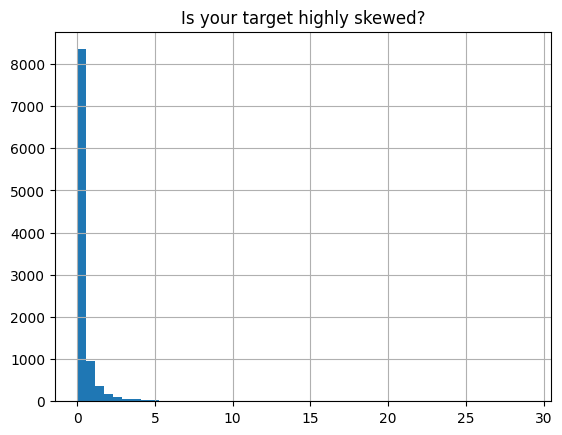

In [31]:
# Look for issues
print(df.isnull().sum())  # Missing values?
print(df.duplicated().sum())  # Duplicates?
print(df.describe())  # Unexpected values?

# Check target variable distribution
df['Global_Sales'].hist(bins=50)
plt.title('Is your target highly skewed?')

In [32]:
# Use the log-transformed target you already created!
y = df['Log_Global_Sales']  # NOT Global_Sales
X = df.drop(columns=['Global_Sales', 'Log_Global_Sales'])

# One-hot encode
X_encoded = pd.get_dummies(X, columns=['Platform', 'Genre', 'Publisher'], drop_first=True)

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred_log = model.predict(X_test)

# Evaluate on log scale
print(f"R² Score (log): {r2_score(y_test, y_pred_log)}")

# Transform back to original scale for interpretation
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)
print(f"R² Score (original): {r2_score(y_test_original, y_pred_original)}")
print(f"RMSE (original): {np.sqrt(mean_squared_error(y_test_original, y_pred_original))}")

R² Score (log): 0.22929980902011782
R² Score (original): 0.10147218698130722
RMSE (original): 1.3846071572699103


In [33]:
# Check the shape of your encoded data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Number of features: {X_encoded.shape[1]}")

# Check how many unique values in categorical columns
print(f"\nUnique Platforms: {df['Platform'].nunique()}")
print(f"Unique Genres: {df['Genre'].nunique()}")
print(f"Unique Publishers: {df['Publisher'].nunique()}")

X_train shape: (8168, 405)
X_test shape: (2042, 405)
Number of features: 405

Unique Platforms: 16
Unique Genres: 12
Unique Publishers: 378


In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# =======================
# STEP 1: Load and prepare data
# =======================
# Assuming your df is already loaded

# Keep only top 20 publishers, group the rest as 'Other'
top_publishers = df['Publisher'].value_counts().head(20).index
df['Publisher_Clean'] = df['Publisher'].apply(lambda x: x if x in top_publishers else 'Other')

print(f"Reduced publishers from {df['Publisher'].nunique()} to {df['Publisher_Clean'].nunique()}")

# =======================
# STEP 2: Feature engineering
# =======================

# Publisher strength
publisher_avg = df.groupby('Publisher')['Global_Sales'].mean()
df['Publisher_Avg_Sales'] = df['Publisher'].map(publisher_avg)

# Platform popularity
platform_counts = df['Platform'].value_counts()
df['Platform_Game_Count'] = df['Platform'].map(platform_counts)

# Genre average sales
genre_avg = df.groupby('Genre')['Global_Sales'].mean()
df['Genre_Avg_Sales'] = df['Genre'].map(genre_avg)

# Publisher frequency (if you don't already have it)
if 'Publisher_freq' not in df.columns:
    publisher_freq = df['Publisher'].value_counts()
    df['Publisher_freq'] = df['Publisher'].map(publisher_freq)

# =======================
# STEP 3: Prepare features
# =======================

# Target variable (log-transformed)
y = np.log1p(df['Global_Sales'])

# Select features
numeric_features = ['Publisher_Avg_Sales', 'Platform_Game_Count', 'Genre_Avg_Sales', 'Publisher_freq']
categorical_features = ['Platform', 'Genre', 'Publisher_Clean']

# Check which numeric features exist
numeric_features = [f for f in numeric_features if f in df.columns]

# Add Year_Adjusted if you have it
if 'Year_Adjusted' in df.columns:
    numeric_features.append('Year_Adjusted')

# Combine features
X = df[numeric_features + categorical_features]

# One-hot encode ONLY the categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"\n{'='*60}")
print(f"Features after encoding: {X_encoded.shape[1]}")
print(f"Feature breakdown:")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Platform categories: ~{df['Platform'].nunique() - 1}")
print(f"  - Genre categories: ~{df['Genre'].nunique() - 1}")
print(f"  - Publisher categories: ~{df['Publisher_Clean'].nunique() - 1}")
print(f"{'='*60}\n")

# =======================
# STEP 4: Train-test split
# =======================

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Samples per feature: {len(X_train) / X_train.shape[1]:.1f}\n")

# =======================
# STEP 5: Train multiple models
# =======================

models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=10,
        subsample=0.8,
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

print(f"{'='*60}")
print("TRAINING MODELS")
print(f"{'='*60}\n")

best_r2 = -999
best_model = None
best_name = ""
best_mae = None

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    # Predictions
    y_pred_log = model.predict(X_test)

    # Log scale metrics
    r2_log = r2_score(y_test, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))

    # Original scale metrics
    y_pred_original = np.expm1(y_pred_log)
    y_test_original = np.expm1(y_test)
    r2_original = r2_score(y_test_original, y_pred_original)
    rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    mae_original = mean_absolute_error(y_test_original, y_pred_original)

    print(f"\n{name} Results:")
    print(f"  R² (log scale):      {r2_log:.4f}")
    print(f"  RMSE (log scale):    {rmse_log:.4f}")
    print(f"  R² (original):       {r2_original:.4f}")
    print(f"  RMSE (original):     {rmse_original:.4f}")
    print(f"  MAE (original):      {mae_original:.4f}")
    print("-" * 60)

    if r2_log > best_r2:
        best_r2 = r2_log
        best_model = model
        best_name = name
        best_mae = mae_original

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_name}")
print(f"R² (log scale): {best_r2:.4f}")
print(f"MAE (original): {best_mae:.4f}")
print(f"{'='*60}\n")

# =======================
# STEP 6: Feature importance
# =======================

if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 20 Most Important Features:")
    print(importances.head(20).to_string(index=False))
    print()

# =======================
# STEP 7: Cross-validation
# =======================

from sklearn.model_selection import cross_val_score

print("Running 5-fold cross-validation...")
cv_scores = cross_val_score(best_model, X_encoded, y, cv=5, scoring='r2', n_jobs=-1)
print(f"CV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# =======================
# FINAL SUMMARY
# =======================

print(f"\n{'='*60}")
print("FINAL MODEL PERFORMANCE SUMMARY")
print(f"{'='*60}")
print(f"Best Model: {best_name}")
print(f"R² Score (log-transformed):  {best_r2:.4f}")
print(f"MAE (original scale):        {best_mae:.4f} million")
print(f"Mean CV R²:                  {cv_scores.mean():.4f}")
print(f"{'='*60}")

Reduced publishers from 378 to 21

Features after encoding: 51
Feature breakdown:
  - Numeric features: 5
  - Platform categories: ~15
  - Genre categories: ~11
  - Publisher categories: ~20

Training samples: 8168
Test samples: 2042
Samples per feature: 160.2

TRAINING MODELS

Training Random Forest...

Random Forest Results:
  R² (log scale):      0.3475
  RMSE (log scale):    0.3268
  R² (original):       0.1334
  RMSE (original):     1.3598
  MAE (original):      0.4102
------------------------------------------------------------
Training Gradient Boosting...

Gradient Boosting Results:
  R² (log scale):      0.3452
  RMSE (log scale):    0.3274
  R² (original):       0.1577
  RMSE (original):     1.3405
  MAE (original):      0.4134
------------------------------------------------------------
Training XGBoost...

XGBoost Results:
  R² (log scale):      0.3515
  RMSE (log scale):    0.3258
  R² (original):       0.1649
  RMSE (original):     1.3348
  MAE (original):      0.4106
---

In [38]:
# After training model WITH publishers
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_with.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importances.head(20))

# Count how many publisher features are in top 20
publisher_features = importances.head(20)[
    importances.head(20)['feature'].str.contains('Publisher|publisher')
]
print(f"\nPublisher features in top 20: {len(publisher_features)}")
print(publisher_features)


Top 20 Most Important Features:
                       feature  importance
0          Publisher_Avg_Sales    0.462142
3              Genre_Avg_Sales    0.102623
2          Platform_Game_Count    0.050656
1               Publisher_freq    0.049254
11                Platform_PS4    0.026328
10                Platform_PS3    0.024256
16               Platform_X360    0.021656
8                  Platform_PC    0.019808
28                Genre_Sports    0.019542
14                Platform_Wii    0.019279
25          Genre_Role-Playing    0.018650
26               Genre_Shooter    0.014291
24                Genre_Racing    0.014228
21                  Genre_Misc    0.013776
30  Publisher_Clean_Activision    0.013491
20              Genre_Fighting    0.013197
22              Genre_Platform    0.008261
18               Platform_XOne    0.007803
5                  Platform_DS    0.007690
42        Publisher_Clean_Sega    0.007548

Publisher features in top 20: 4
                       feature 

In [41]:
# Publisher's best-selling game
publisher_max = df.groupby('Publisher')['Global_Sales'].max()
df['Publisher_Best_Game'] = df['Publisher'].map(publisher_max)

# Publisher's median sales (more robust than average)
publisher_median = df.groupby('Publisher')['Global_Sales'].median()
df['Publisher_Median_Sales'] = df['Publisher'].map(publisher_median)

# How consistent is this publisher? (standard deviation)
publisher_std = df.groupby('Publisher')['Global_Sales'].std()
df['Publisher_Consistency'] = df['Publisher'].map(publisher_std)

In [44]:
import numpy as np

# =======================
# ADD NEW FEATURES (NO 'Name' COLUMN NEEDED)
# =======================

print("Adding new features...")

# 1. Publisher hit rate (% of games that sold >1M)
def hit_rate(group):
    return (group > 1.0).sum() / len(group) if len(group) > 0 else 0

publisher_hit_rate = df.groupby('Publisher')['Global_Sales'].apply(hit_rate)
df['Publisher_Hit_Rate'] = df['Publisher'].map(publisher_hit_rate)

# 2. Publisher consistency (standard deviation = risk)
publisher_std = df.groupby('Publisher')['Global_Sales'].std().fillna(0)
df['Publisher_Risk'] = df['Publisher'].map(publisher_std)

# 3. Publisher best game ever
publisher_max = df.groupby('Publisher')['Global_Sales'].max()
df['Publisher_Best_Game'] = df['Publisher'].map(publisher_max)

# 4. Platform-Genre interaction (top 20 combos only)
df['Platform_Genre'] = df['Platform'].astype(str) + '_' + df['Genre'].astype(str)
top_combos = df['Platform_Genre'].value_counts().head(20).index
df['Platform_Genre_Top'] = df['Platform_Genre'].apply(lambda x: x if x in top_combos else 'Other')

# 5. Publisher-Genre specialization
df['Publisher_Genre_Strength'] = df.groupby(['Publisher', 'Genre'])['Global_Sales'].transform('mean')

# 6. Publisher × Genre interaction (numeric)
if 'Publisher_Avg_Sales' in df.columns and 'Genre_Avg_Sales' in df.columns:
    df['PubAvg_x_GenreAvg'] = df['Publisher_Avg_Sales'] * df['Genre_Avg_Sales']

# 7. Console generation (if you have Year)
if 'Year' in df.columns:
    def get_gen(year):
        if year <= 2012:
            return 'Gen7'
        else:
            return 'Gen8'

    df['Console_Gen'] = df['Year'].apply(get_gen)

print("\n✅ Successfully added new features!")
print(f"DataFrame shape: {df.shape}")
print("\nColumns added:")
print("  ✓ Publisher_Hit_Rate")
print("  ✓ Publisher_Risk")
print("  ✓ Publisher_Best_Game")
print("  ✓ Platform_Genre_Top")
print("  ✓ Publisher_Genre_Strength")
if 'PubAvg_x_GenreAvg' in df.columns:
    print("  ✓ PubAvg_x_GenreAvg")
if 'Console_Gen' in df.columns:
    print("  ✓ Console_Gen")

Adding new features...

✅ Successfully added new features!
DataFrame shape: (10210, 20)

Columns added:
  ✓ Publisher_Hit_Rate
  ✓ Publisher_Risk
  ✓ Publisher_Best_Game
  ✓ Platform_Genre_Top
  ✓ Publisher_Genre_Strength
  ✓ PubAvg_x_GenreAvg


In [46]:
import numpy as np

# =======================
# ADD NEW FEATURES (NO 'Name' COLUMN NEEDED)
# =======================

print("Adding new features...")

# 1. Publisher hit rate (% of games that sold >1M)
def hit_rate(group):
    return (group > 1.0).sum() / len(group) if len(group) > 0 else 0

publisher_hit_rate = df.groupby('Publisher')['Global_Sales'].apply(hit_rate)
df['Publisher_Hit_Rate'] = df['Publisher'].map(publisher_hit_rate)

# 2. Publisher consistency (standard deviation = risk)
publisher_std = df.groupby('Publisher')['Global_Sales'].std().fillna(0)
df['Publisher_Risk'] = df['Publisher'].map(publisher_std)

# 3. Publisher best game ever
publisher_max = df.groupby('Publisher')['Global_Sales'].max()
df['Publisher_Best_Game'] = df['Publisher'].map(publisher_max)

# 4. Platform-Genre interaction (top 20 combos only)
df['Platform_Genre'] = df['Platform'].astype(str) + '_' + df['Genre'].astype(str)
top_combos = df['Platform_Genre'].value_counts().head(20).index
df['Platform_Genre_Top'] = df['Platform_Genre'].apply(lambda x: x if x in top_combos else 'Other')

# 5. Publisher-Genre specialization
df['Publisher_Genre_Strength'] = df.groupby(['Publisher', 'Genre'])['Global_Sales'].transform('mean')

# 6. Publisher × Genre interaction (numeric)
if 'Publisher_Avg_Sales' in df.columns and 'Genre_Avg_Sales' in df.columns:
    df['PubAvg_x_GenreAvg'] = df['Publisher_Avg_Sales'] * df['Genre_Avg_Sales']

# 7. Console generation (if you have Year)
if 'Year' in df.columns:
    def get_gen(year):
        if year <= 2012:
            return 'Gen7'
        else:
            return 'Gen8'

    df['Console_Gen'] = df['Year'].apply(get_gen)

print("\n✅ Successfully added new features!")
print(f"DataFrame shape: {df.shape}")
print("\nColumns added:")
print("  ✓ Publisher_Hit_Rate")
print("  ✓ Publisher_Risk")
print("  ✓ Publisher_Best_Game")
print("  ✓ Platform_Genre_Top")
print("  ✓ Publisher_Genre_Strength")
if 'PubAvg_x_GenreAvg' in df.columns:
    print("  ✓ PubAvg_x_GenreAvg")
if 'Console_Gen' in df.columns:
    print("  ✓ Console_Gen")

Adding new features...

✅ Successfully added new features!
DataFrame shape: (10210, 20)

Columns added:
  ✓ Publisher_Hit_Rate
  ✓ Publisher_Risk
  ✓ Publisher_Best_Game
  ✓ Platform_Genre_Top
  ✓ Publisher_Genre_Strength
  ✓ PubAvg_x_GenreAvg


# MODEL EVALUATION (25 min)


## Classification and Regression
* Accuracy
* Precision @ k
* Recall @ k
* F1 Score
* Confusion Matrix

## Regression
* SSE (Sum of Squares Error)
* SAE (Sum of Absolute Error)

## Clustering
* Sillhoutte Score
* Elbow method

In [ ]:
# Evaluate your model here
from sklearn.metrics import

# Conclusion
